# Calculate emissions changes in well-mixed gas levels
Calculate the emissions changes in well-mixed gases at hemisphereic and globally averaged levels. 

In [1]:
import netCDF4 as nc
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point

In [2]:
# Input gas levels
input_folder = "../input/"
output_folder = "../output/"
input_co2_mole = "mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-0_gr1-GMNHSH_2015-2500.nc"
input_no2_mole = "mole-fraction-of-nitrous-oxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_ch4_mole = "mole-fraction-of-methane-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-0_gr1-GMNHSH_201501-250012.nc"

# We need to know the names of relevant variables in each of the different files
gases = {"co2": input_co2_mole, "n2o": input_no2_mole, "ch4": input_ch4_mole}
key_variables = {
    "co2": "mole_fraction_of_{}_in_air".format("carbon_dioxide"),
    "n2o": "mole_fraction_of_{}_in_air".format("nitrous_oxide"), #TODO: check this
    "ch4": "mole_fraction_of_{}_in_air".format("methane"), #TODO: check this
}
path_var_names = {"co2": "co2(GtC/year)", "n2o": "n2o(MtC/year)", "ch4": "ch4(MtC/year)"}

# input_co2_air = "CO2-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"

# Modification factors
mod_input_folder = "../../COVID19_emissions_data/global_pathways/"
mod_input_baseline = "Base_pathway.xlsx"
mod_input_ff = "FossilFuel_pathway.xlsx"
mod_input_2yr= "TwoYearBlip_pathway.xlsx"
mod_input_mg = "ModerateGreen_pathway.xlsx"
mod_input_sg = "StrongGreen_pathway.xlsx"

pathway_files = [mod_input_ff, mod_input_2yr, mod_input_mg, mod_input_sg]

year_range = np.arange(2020, 2051)

In [3]:
baseline = pd.read_excel(mod_input_folder + mod_input_baseline, header=0, index_col=0)
baseline

,year,co2_fossil(GtC/year),co2_land(GtC/year),ch4(Mt/year),n2o(Mt(N2)/year),sox(MtS/year),co(Mt/year),nmvoc(Mt/year),nox(MtN/year),bc(Mt/year),...,mcf(kt/year),hcfc22(kt/year),hcfc141b(kt/year),hcfc142b(kt/year),halon1211(kt/year),halon1202(kt/year),halon1301(kt/year),halon2402(kt/year),ch3br(kt/year),ch3cl(kt/year)
0,1765.000000,0.003000,0.106600,20.919200,0.072484,1.248800,352.932700,60.629500,3.876800,2.123600,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,157.267,3100.211
1,1765.083333,0.003033,0.106767,20.913733,0.072598,1.248250,352.636692,60.565275,3.877358,2.122508,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,157.267,3100.211
2,1765.166667,0.003067,0.106933,20.908267,0.072712,1.247700,352.340683,60.501050,3.877917,2.121417,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,157.267,3100.211
3,1765.250000,0.003100,0.107100,20.902800,0.072826,1.247150,352.044675,60.436825,3.878475,2.120325,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,157.267,3100.211
4,1765.333333,0.003133,0.107267,20.897333,0.072940,1.246600,351.748667,60.372600,3.879033,2.119233,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,157.267,3100.211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,2049.666667,11.366927,0.185763,311.250754,7.217255,24.192076,657.138506,159.068057,38.813775,4.633620,...,0.0,62.628333,27.068667,2.039333,0.294333,0.0,0.198667,0.002,155.925,3511.082
3417,2049.750000,11.371774,0.180894,311.159336,7.218625,24.158206,656.617372,158.992463,38.790283,4.629264,...,0.0,61.885500,26.952000,2.025000,0.292500,0.0,0.197750,0.002,155.925,3511.082
3418,2049.833333,11.376621,0.176025,311.067918,7.219996,24.124337,656.096237,158.916869,38.766791,4.624908,...,0.0,61.142667,26.835333,2.010667,0.290667,0.0,0.196833,0.002,155.925,3511.082
3419,2049.916667,11.381469,0.171156,310.976499,7.221366,24.090467,655.575103,158.841275,38.743299,4.620552,...,0.0,60.399833,26.718667,1.996333,0.288833,0.0,0.195917,0.002,155.925,3511.082


In [4]:
# Average the CO2 values
baseline["co2(GtC/year)"] = baseline["co2_fossil(GtC/year)"] + baseline["co2_land(GtC/year)"]

In [5]:
def calc_means(df, year_range):
    to_return = pd.DataFrame(index=year_range, columns=["mean"])
    for year in year_range:
        to_return["mean"][year] = np.nanmean(df[df["year"].floordiv(1) == year][df.columns[1]])
    return to_return

In [6]:
baseline_means = calc_means(baseline[["year", "co2(GtC/year)"]], year_range)

In [7]:
baseline_means.head()

,mean
2020,11.1104
2021,11.1643
2022,11.2181
2023,11.272
2024,11.3258


In [8]:
def make_year_into_days(year):
    return (year - 1850 + 0.5) * 365 # The calendar is defined using the 365 day calendar. 

In [9]:
gas = "co2"
gas_file = gases[gas]
key_variable = key_variables[gas]

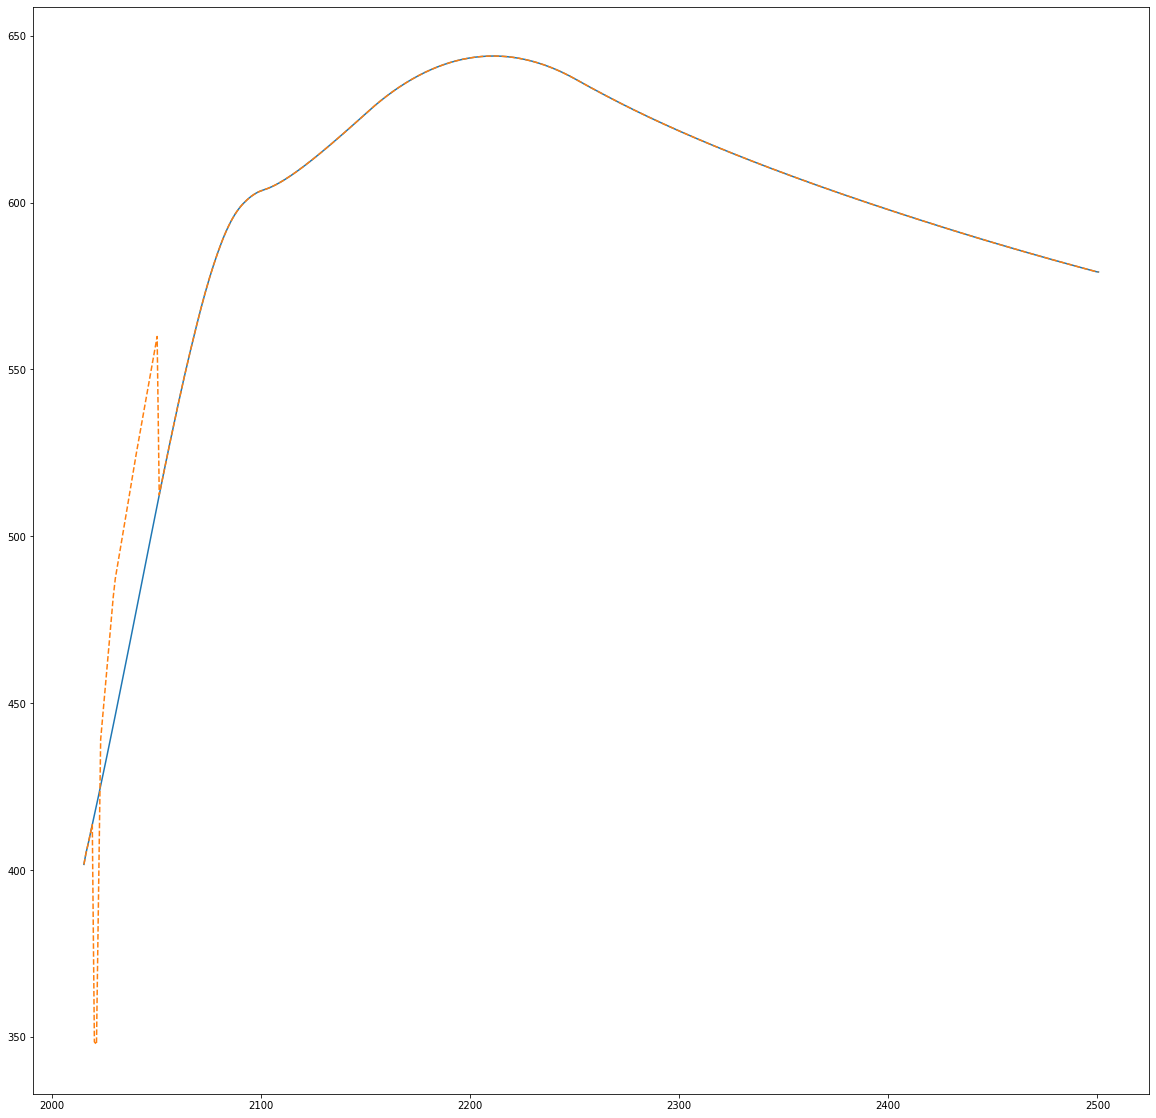

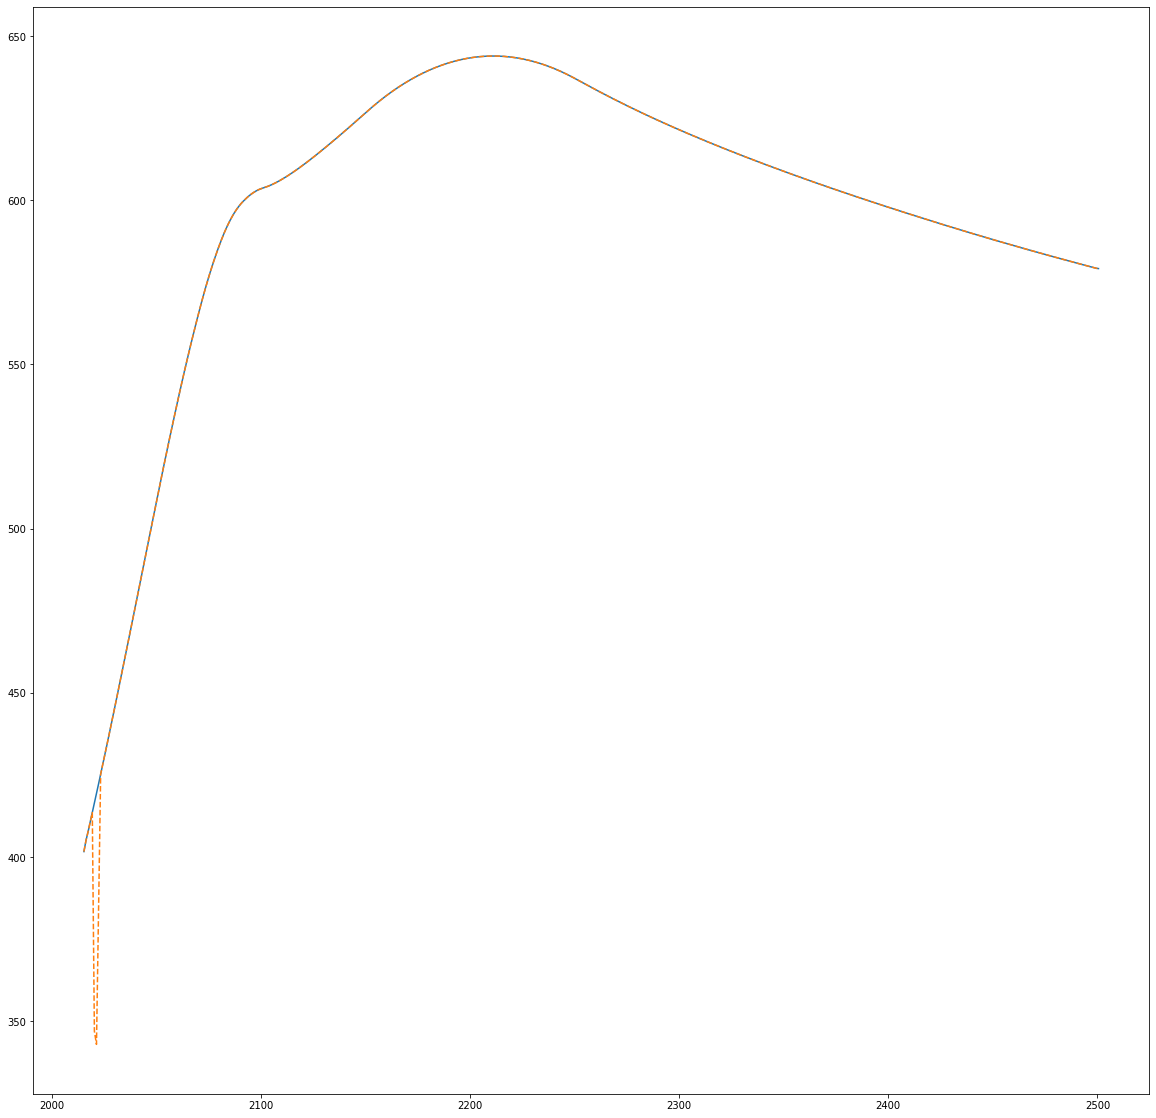

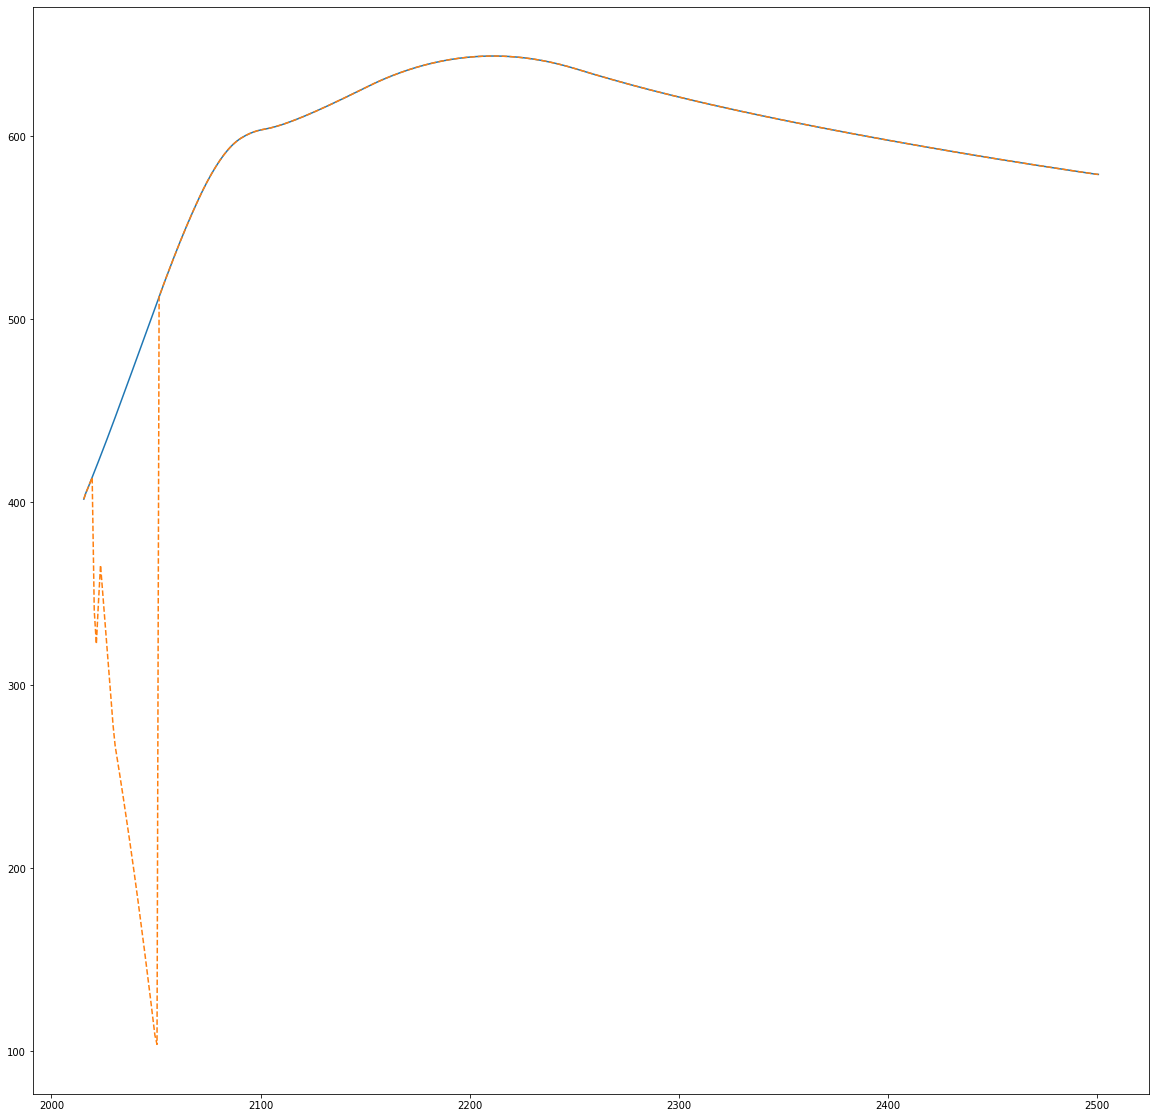

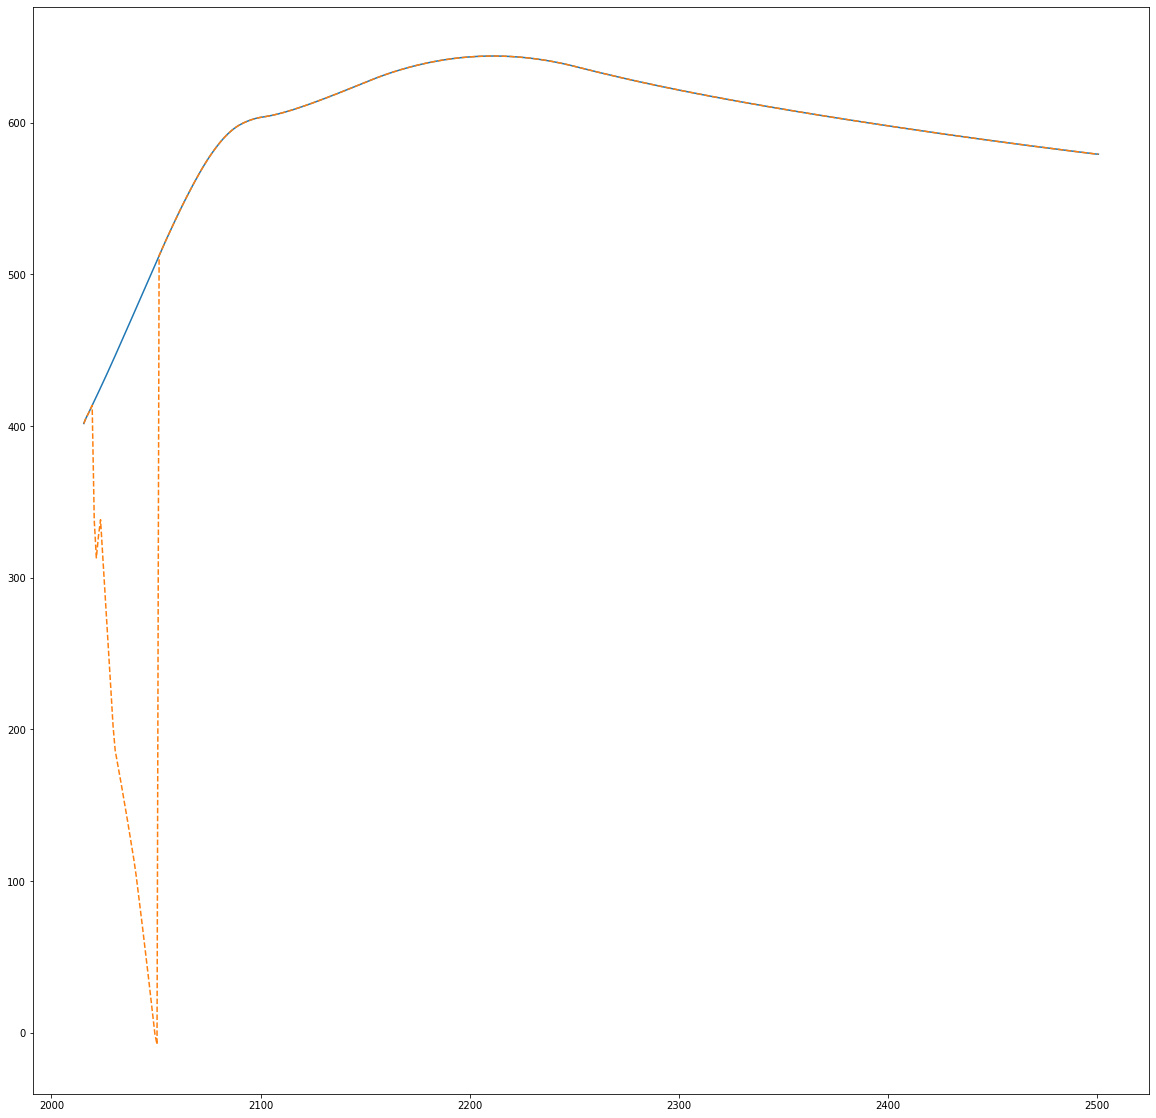

In [10]:
for fileind in range(len(pathway_files)): # TODO: use all
    file = pathway_files[fileind]
    scenario_string = file.split("_")[0]
    data = copy_netcdf_file(gas_file, input_folder, output_folder, scenario_string)
    output = data.variables[key_variable][...]
    path_df = pd.read_excel(mod_input_folder + file, header=0, index_col=0)
    if gas == "co2":
        path_df["co2(GtC/year)"] = path_df["co2_fossil(GtC/year)"] + path_df["co2_land(GtC/year)"]
    path_means = calc_means(path_df[["year", path_var_names[gas]]], year_range)
    for time in year_range:
        timeind = np.where(data.variables["time"][:] == make_year_into_days(time))[0]
        time_factor = path_means.loc[time] / baseline_means.loc[time]
        output[timeind, ...] *= time_factor[0]
    # good_times = np.where(data.variables["time"][:] <= make_year_into_days(max(year_range)))[0] # use to limit time dur
    plt.figure(figsize=(20, 20))
    plt.plot(data.variables["time"][:] / 365 + 1850, data.variables[key_variable][:, 1])
    plt.plot(data.variables["time"][:] / 365 + 1850, output[:, 1], linestyle="--")
    data.variables[key_variable][:, :] = output
    data.close()

# Sandbox

In [11]:
blob

NameError: name 'blob' is not defined

In [ ]:
data.close()

In [ ]:
data.variables[key_variable][:, :] = output

In [ ]:
plt.plot(data.variables["time"][good_times] / 365 + 1850, data.variables[key_variable][good_times, 1])

In [ ]:
plt.plot(data.variables["time"][:] / 365 + 1850, data.variables[key_variable][:, 1])